In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [117]:
# GPU利用可なら自動的に切り替え
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cuda


In [118]:
import pandas as pd
df = pd.read_csv(r"/root/workspace/gaze.csv")

/tmp/ipykernel_10601/749066812.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/root/workspace/gaze.csv")


In [119]:
df.columns.tolist()

['Unnamed: 0',
 'time',
 'time2',
 'left_x',
 'left_y',
 'right_x',
 'right_y',
 'left_pupil',
 'right_pupil',
 'score',
 'q_category',
 'question',
 'Q',
 'CD_RISC_TOTAL',
 'CD_RISC_READING',
 'CD_RISC_MEMORY',
 'CD_RISC_RECOGNITION',
 'CD_RISC_ATTENTION',
 'SRS_18',
 'ERQ_EVALUATION_AVE',
 'ERQ_SUPPRESSION_AVE',
 'Time',
 'device_time_stamp',
 'system_time_stamp',
 'pc_time_stamp']

In [120]:
import numpy as np
# Xとyに分割
X = df[['left_x', 'left_y', 'right_x', 'right_y', 'left_pupil', 'right_pupil']].values

# pandas DataFrame化
X_df = pd.DataFrame(X)
# 線形補間（欠損が連続しても対応）
X_df = X_df.interpolate(method='linear', limit_direction='both')
# 補間後のNaNを0で埋める（端の安全策）
X_df = X_df.fillna(0)
# numpy配列に戻す
X = X_df.to_numpy().astype(np.float32)

df['score'] = df['score'].replace({2:1})
y = df['score'].values

In [121]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (974230, 6)
y shape: (974230,)


In [122]:
from scipy.stats import mode
# ======================================
# 🪄 3. 時系列データをTransformer入力形式に変換
# ======================================
seq_len = 100
feature_dim = X.shape[1]
num_classes = 2

num_sequences = X.shape[0] // seq_len
X = X[:num_sequences * seq_len]
y = y[:num_sequences * seq_len]

X = X.reshape(num_sequences, seq_len, feature_dim)
y = y.reshape(num_sequences, seq_len)

# 各系列の代表ラベル：多数決 or 最終時点ラベル
y = mode(y, axis=1, keepdims=False)[0]
# y = y[:, -1]  # ←最終ステップのラベルにする場合はこちら

print("系列数:", num_sequences)
print("X:", X.shape, " y:", y.shape)

系列数: 9742
X: (9742, 100, 6)  y: (9742,)


In [123]:
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import StratifiedShuffleSplit
# ======================================
# 🔢 TensorDataset 作成
# ======================================
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

# ======================================
# ⚖️ 層化分割 (train/val/test)
# ======================================
test_ratio = 0.15
val_ratio = 0.15

# --- まず train+val と test に分割 ---
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)
trainval_idx, test_idx = next(sss1.split(X, y))

# --- 次に train+val を train と val に分割 ---
y_trainval = y[trainval_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio / (1 - test_ratio), random_state=42)
train_idx, val_idx = next(sss2.split(X[trainval_idx], y_trainval))

# --- インデックスをTensorDatasetに適用 ---
train_ds = Subset(dataset, trainval_idx[train_idx])
val_ds   = Subset(dataset, trainval_idx[val_idx])
test_ds  = Subset(dataset, test_idx)

# ======================================
# 📦 DataLoader作成
# ======================================
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"train: {len(train_ds)}  val: {len(val_ds)}  test: {len(test_ds)}")

train: 6818  val: 1462  test: 1462


In [124]:
# ======== クラス分布の確認 ========
import numpy as np

def check_class_ratio(y, idx):
    vals, counts = np.unique(y[idx], return_counts=True)
    ratio = counts / counts.sum()
    return dict(zip(vals, ratio))

print("Train:", check_class_ratio(y, trainval_idx[train_idx]))
print("Val:  ", check_class_ratio(y, trainval_idx[val_idx]))
print("Test: ", check_class_ratio(y, test_idx))

Train: {0: 0.311088295687885, 1: 0.688911704312115}
Val:   {0: 0.3112175102599179, 1: 0.688782489740082}
Test:  {0: 0.3112175102599179, 1: 0.688782489740082}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ======================================
# 🧠 Transformer分類器（nn.Module）
# ======================================
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        feature_dim: int = 6,
        hidden_dim: int = 32,
        num_heads: int = 2,
        num_layers: int = 2,
        num_classes: int = 2,
        dropout: float = 0.1,
        activation: str = "relu",
        return_sequence: bool = False,  # Trueにすると系列特徴を返すユーティリティ用
        max_len: int = 1024,
    ):
        super().__init__()
        self.return_sequence = return_sequence

        self.embedding = nn.Linear(feature_dim, hidden_dim)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True,  # 安定化（お好みでFalseでも可）
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Global Average Pooling (L dimension)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B, L, _ = x.size()
        h = self.embedding(x)
        pos = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        h = h + self.pos_emb(pos)  # ★位置情報を加算

        h = self.transformer(h)
        h = h.transpose(1, 2)
        h = self.pool(h).squeeze(-1)
        logits = self.fc(h)
        return logits

    # ---------- 解析ユーティリティ ----------
    @torch.no_grad()
    def extract_sequence(self, x):
        """Transformer出力の系列テンソル (B, L, H) を取得"""
        self.eval()
        return self.forward_with_sequence(x)

    def forward_with_sequence(self, x):
        """内部で系列特徴を得るためのヘルパ（学習時にも使用可）"""
        B, L, _ = x.size()
        h = self.embedding(x)
        pos = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        h = h + self.pos_emb(pos)  # ★
        h = self.transformer(h)    # (B, L, H)
        return h

    @torch.no_grad()
    def extract_pooled(self, x):
        """GlobalAvgPool後の (B, H) を取得（潜在ベクトル可視化などに）"""
        self.eval()
        h_seq = self.forward_with_sequence(x)      # (B, L, H)
        h = self.pool(h_seq.transpose(1, 2)).squeeze(-1)  # (B, H)
        return h


In [107]:
# ======================================
# 🧠 5. Transformerモデル構築（関数・クラス未使用）
# ======================================
feature_dim = 6
hidden_dim = 32
num_heads = 2
num_layers = 2
num_classes = 2
dropout = 0.1

# 既存の device を使用
model = TransformerClassifier(
    feature_dim=feature_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout,
).to(device)

# ======================================
# ⚙️ 6. 損失関数・最適化手法
# ======================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-2
)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [90]:
# ======================================
# 🧠 EarlyStopping クラス定義
# ======================================
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.01):
        """
        patience : 改善が止まってから何エポック待つか
        min_delta : 改善とみなす最小の変化量
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.should_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

In [91]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import numpy as np
# ======================================
# 🏋️‍♂️ 7. 学習ループ（Validation + EarlyStopping）
# ======================================
num_epochs = 500
patience = 30  # 30エポック改善しなければ終了
early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_model_state = None

for epoch in range(num_epochs):
    # --------------------------
    # 🔹 Training
    # --------------------------
    model.train()
    train_loss, all_preds, all_trues = 0, [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)

        # Loss & Backprop
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(yb.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc = accuracy_score(all_trues, all_preds)

    # --------------------------
    # 🔹 Validation
    # --------------------------
    model.eval()
    val_loss, val_preds, val_trues = 0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_trues.extend(yb.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_trues, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"TrainLoss: {train_loss:.4f} ValLoss: {val_loss:.4f} " f"TrainAcc: {train_acc:.4f} ValAcc: {val_acc:.4f}")

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"⏹ Early Stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
        break

Epoch [1/500] TrainLoss: 0.6236 ValLoss: 0.6215 TrainAcc: 0.6889 ValAcc: 0.6888
Epoch [2/500] TrainLoss: 0.6223 ValLoss: 0.6206 TrainAcc: 0.6889 ValAcc: 0.6888
Epoch [3/500] TrainLoss: 0.6217 ValLoss: 0.6199 TrainAcc: 0.6889 ValAcc: 0.6888
Epoch [4/500] TrainLoss: 0.6203 ValLoss: 0.6189 TrainAcc: 0.6889 ValAcc: 0.6888
Epoch [5/500] TrainLoss: 0.6201 ValLoss: 0.6184 TrainAcc: 0.6889 ValAcc: 0.6888
Epoch [6/500] TrainLoss: 0.6196 ValLoss: 0.6186 TrainAcc: 0.6889 ValAcc: 0.6888
Epoch [7/500] TrainLoss: 0.6183 ValLoss: 0.6172 TrainAcc: 0.6889 ValAcc: 0.6888
Epoch [8/500] TrainLoss: 0.6180 ValLoss: 0.6171 TrainAcc: 0.6894 ValAcc: 0.6895
Epoch [9/500] TrainLoss: 0.6183 ValLoss: 0.6206 TrainAcc: 0.6898 ValAcc: 0.6902
Epoch [10/500] TrainLoss: 0.6173 ValLoss: 0.6157 TrainAcc: 0.6898 ValAcc: 0.6902
Epoch [11/500] TrainLoss: 0.6167 ValLoss: 0.6180 TrainAcc: 0.6899 ValAcc: 0.6895
Epoch [12/500] TrainLoss: 0.6172 ValLoss: 0.6154 TrainAcc: 0.6899 ValAcc: 0.6902
Epoch [13/500] TrainLoss: 0.6169 ValL

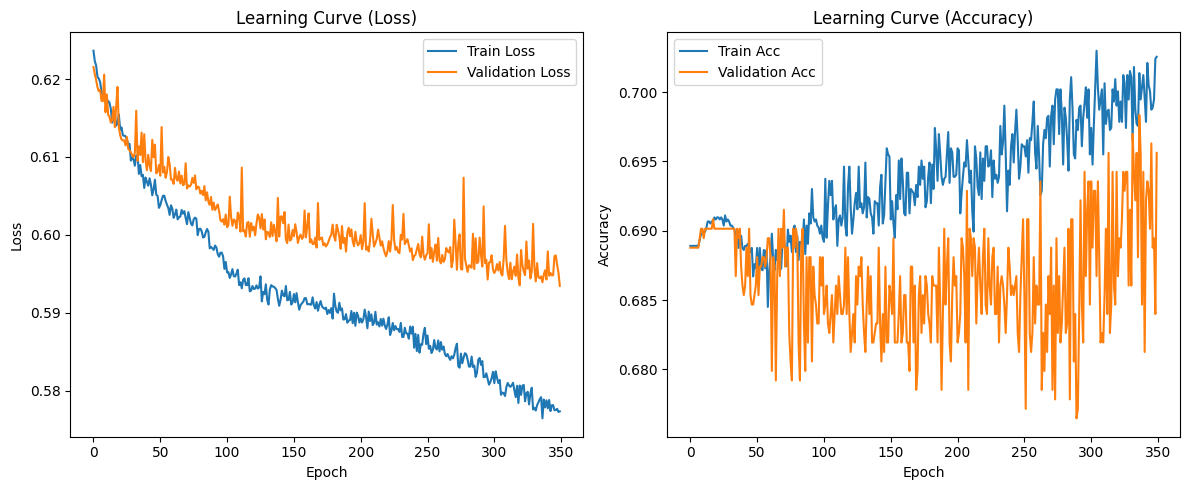

In [92]:
# ======================================
# 📊 学習曲線の可視化
# ======================================
plt.figure(figsize=(12, 5))

# --- Loss 曲線 ---
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()

# --- Accuracy 曲線 ---
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.legend()

plt.tight_layout()
plt.show()

In [93]:
# ======================================
# 💾 ベストモデル保存（任意）
# ======================================

best_model_state = {
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "hparams": {
        "feature_dim": feature_dim,
        "hidden_dim": hidden_dim,
        "num_heads": num_heads,
        "num_layers": num_layers,
        "num_classes": num_classes,
        "dropout": dropout,
    },
    "epoch": epoch,
}
import datetime
import pytz
jst = pytz.timezone('Asia/Tokyo')
now = datetime.datetime.now(jst)
time = now.strftime('%Y%m%d_%H:%M')
torch.save(best_model_state, f"best_model_{time}.pth")


In [ ]:
# 復元
# ckpt = torch.load("/root/workspace/深層学習/20251111/best_model_20251111_06:25.pth", map_location=device)
# model = TransformerClassifier(**ckpt["hparams"]).to(device)
# model.load_state_dict(ckpt["model_state"])
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
# optimizer.load_state_dict(ckpt["optimizer_state"])


/tmp/ipykernel_10601/1461131087.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/root/workspace/深層学習/20251111/best_model_20251111_06:25.pth", map_loca

In [94]:
from sklearn.metrics import classification_report
# ======================================
# 🧾 8. テストデータで評価
# ======================================
model_loss = 0
all_preds = []
all_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        logits = model(xb)
        
        loss = criterion(logits, yb)
        model_loss += loss.item()
        
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(yb.cpu().numpy())

test_acc = accuracy_score(all_trues, all_preds)
print(f"Test Loss: {model_loss/len(test_loader):.4f}  Test Acc: {test_acc:.4f}")
print(classification_report(all_trues, all_preds, digits=4))

Test Loss: 0.5919  Test Acc: 0.6956
              precision    recall  f1-score   support

           0     0.5347    0.1692    0.2571       455
           1     0.7132    0.9335    0.8086      1007

    accuracy                         0.6956      1462
   macro avg     0.6240    0.5513    0.5328      1462
weighted avg     0.6577    0.6956    0.6370      1462



In [95]:
from torchvista import trace_model

trace_model(model, xb)

In [98]:
# ======================================
# 🔮 9. 推論サンプル
# ======================================
# 1系列分のダミーデータで確認
sample = torch.randn(1, seq_len, feature_dim).to(device)
softmax = nn.Softmax(dim=1)

logits = model(sample)
out = softmax(logits)

pred_class = torch.argmax(out, dim=1).item()
print("出力確率:", out.detach().cpu().numpy())
print("予測クラス:", pred_class)

出力確率: [[0.6694373  0.33056274]]
予測クラス: 0


# 潜在ベクトル可視化

In [99]:
# ======================================
# 🧩 潜在ベクトル抽出
# ======================================

latent_vectors = []
true_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)

        # Transformerの系列出力 (B, L, H)
        h_seq = model.forward_with_sequence(xb) # Transformer層を通ったあとの状態
        # h_seq = model.extract_pooled(xb) # Pooling層を通ったあとの状態

        # 系列平均を潜在ベクトルに（Global Average Pooling と等価）
        latent = h_seq.mean(dim=1)          # (B, H)

        latent_vectors.append(latent.cpu())
        true_labels.append(yb.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0)  # (N, H)
true_labels    = torch.cat(true_labels, dim=0)     # (N,)
print("潜在ベクトル形状:", latent_vectors.shape)

潜在ベクトル形状: torch.Size([1462, 32])


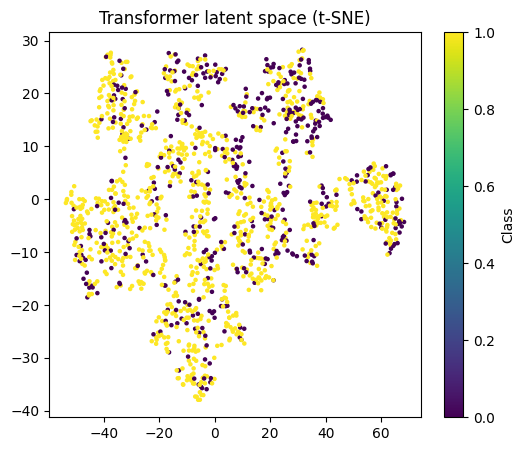

In [100]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(6,5))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=true_labels, cmap="viridis", s=5)
plt.colorbar(label="Class")
plt.title("Transformer latent space (t-SNE)")
plt.show()

In [101]:
# ======================================
# 🧩 潜在ベクトル抽出（extract_pooled 版）
# ======================================
model.eval()

latent_list = []
label_list  = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        # (B, H) を取得（学習時と同じ GlobalAvgPool 後の表現）
        h = model.extract_pooled(xb)     # (batch, hidden_dim)
        latent_list.append(h.cpu())
        label_list.append(yb.cpu())

latent_vectors = torch.cat(latent_list, dim=0)   # (N, hidden_dim)
true_labels    = torch.cat(label_list,  dim=0)   # (N,)
print("潜在ベクトル形状:", latent_vectors.shape, " ラベル形状:", true_labels.shape)

潜在ベクトル形状: torch.Size([1462, 32])  ラベル形状: torch.Size([1462])


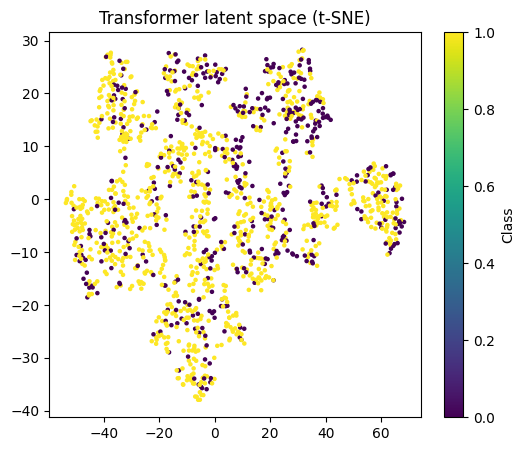

In [102]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(6,5))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=true_labels, cmap="viridis", s=5)
plt.colorbar(label="Class")
plt.title("Transformer latent space (t-SNE)")
plt.show()

# 潜在ベクトルをLightGBMに入力

In [ ]:
import lightgbm as lgb
modelml = lgb.LGBMClassifier()
modelml.fit(latent_vectors.numpy(), true_labels.numpy())
print("LightGBM acc:", modelml.score(latent_vectors.numpy(), true_labels.numpy()))

[LightGBM] [Info] Number of positive: 1007, number of negative: 455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.688782 -> initscore=0.794433
[LightGBM] [Info] Start training from score 0.794433
LightGBM acc: 0.9993160054719562


In [104]:
true_labels.shape

torch.Size([1462])

# アテンション可視化

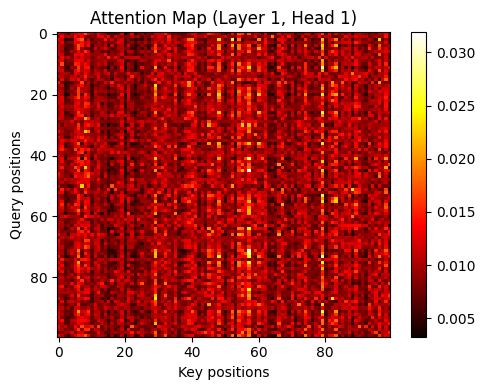

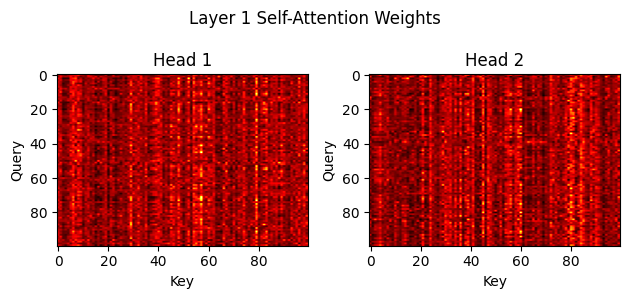

In [109]:
# ======================================
# 👁️ アテンション可視化（第1層の自己注意）
# ======================================
import torch
import matplotlib.pyplot as plt

model.eval()

# 1系列サンプルを取得
sample, _ = next(iter(test_loader))
sample = sample[:1].to(device)    # (1, L, F)

with torch.no_grad():
    # ---- 埋め込み ----
    h = model.embedding(sample)   # (1, L, H)

    # ---- [CLS] と Positional Embedding を再現（あれば）----
    use_cls = hasattr(model, "cls_token")
    use_pos = hasattr(model, "pos_emb")

    if use_cls:
        cls = model.cls_token.expand(h.size(0), 1, -1)   # (1,1,H)
        h = torch.cat([cls, h], dim=1)                   # (1, L+1, H)

    if use_pos:
        L = h.size(1)
        pos = torch.arange(L, device=h.device).unsqueeze(0).expand(h.size(0), L)  # (1, L)
        h = h + model.pos_emb(pos)

    # ---- 第1層を取得 & 入力の正規化（norm_first対応）----
    layer0 = model.transformer.layers[0]
    if getattr(layer0, "norm_first", False):
        qkv_in = layer0.norm1(h)
    else:
        qkv_in = h

    # ---- 自己注意を直接呼び出し（重み取得）----
    # MultiheadAttention は batch_first=True（EncoderLayer作成時と同じ）
    attn_out, attn_weights = layer0.self_attn(
        qkv_in, qkv_in, qkv_in,
        need_weights=True,
        average_attn_weights=False  # => (B, num_heads, L, L)
    )

# ---- 可視化（1ヘッド目）----
attn = attn_weights[0, 0].detach().cpu().numpy()  # (L, L)
plt.figure(figsize=(5, 4))
plt.imshow(attn, cmap='hot', interpolation='nearest', aspect='auto')
title = "Attention Map (Layer 1, Head 1)"
if use_cls:
    title += "  [with CLS]"
plt.title(title)
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar()
plt.tight_layout()
plt.show()

# ---- すべてのヘッドをグリッドで表示（任意）----
num_heads = attn_weights.size(1)
cols = min(num_heads, 4)
rows = (num_heads + cols - 1) // cols

plt.figure(figsize=(3.2*cols, 3.0*rows))
for h_idx in range(num_heads):
    ax = plt.subplot(rows, cols, h_idx + 1)
    ax.imshow(attn_weights[0, h_idx].detach().cpu().numpy(), cmap='hot', aspect='auto')
    ax.set_title(f"Head {h_idx+1}")
    ax.set_xlabel("Key")
    ax.set_ylabel("Query")
plt.suptitle("Layer 1 Self-Attention Weights")
plt.tight_layout()
plt.show()


In [126]:
def _prepare_emb_with_pos_cls(model, x):
    """
    model: TransformerClassifier
    x: (B, L, F)
    return: h (B, L' , H)  # L' は [CLS] ありなら L+1
    """
    h = model.embedding(x)                     # (B, L, H)

    use_cls = hasattr(model, "cls_token")
    use_pos = hasattr(model, "pos_emb")

    if use_cls:
        cls = model.cls_token.expand(h.size(0), 1, -1)  # (B,1,H)
        h = torch.cat([cls, h], dim=1)                  # (B,L+1,H)

    if use_pos:
        B, L, H = h.size()
        pos = torch.arange(L, device=h.device).unsqueeze(0).expand(B, L)  # (B,L)
        h = h + model.pos_emb(pos)                  # 位置埋め込み加算

    return h

@torch.no_grad()
def get_layer_k_attn_weights(model, x, k: int, average_heads: bool=False):
    """
    第 k 層 (0-index) の自己注意重みを取得
    returns:
      attn_weights: (B, num_heads, L, L)  もしくは average_heads=True なら (B, L, L)
      h_in_k: 第k層入力 (B, L, H)  # デバッグ/可視化用
    """
    model.eval()
    h = _prepare_emb_with_pos_cls(model, x)        # (B, L', H)
    n_layers = len(model.transformer.layers)
    assert 0 <= k < n_layers, f"k は 0～{n_layers-1} にしてください"

    # 0..k-1 層を通常どおり前進
    for i in range(k):
        h = model.transformer.layers[i](h)

    # 第k層の self_attn を直接呼び、重みを取得
    layer_k = model.transformer.layers[k]

    # norm_first に応じて、自己注意への入力を合わせる
    if getattr(layer_k, "norm_first", False):
        qkv_in = layer_k.norm1(h)
    else:
        qkv_in = h

    # MultiheadAttention は batch_first=True（EncoderLayer作成時と同じ想定）
    attn_out, attn_weights = layer_k.self_attn(
        qkv_in, qkv_in, qkv_in,
        need_weights=True,
        average_attn_weights=average_heads
    )
    # 形状: average_heads=False => (B, num_heads, L, L)
    #       average_heads=True  => (B, L, L)
    return attn_weights, qkv_in  # qkv_in を第k層の入力として返す（任意で使える）

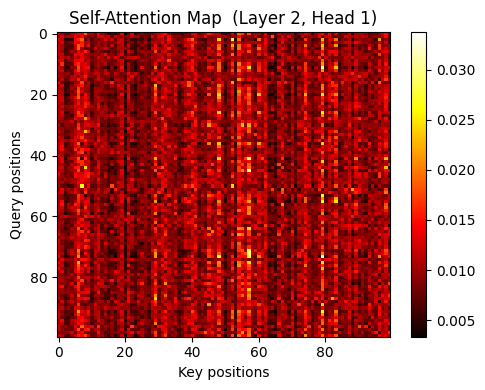

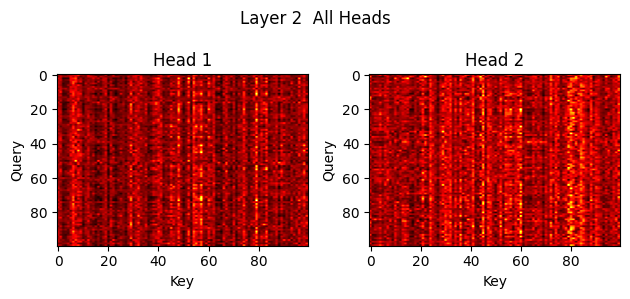

In [127]:
import torch
import matplotlib.pyplot as plt
# ===== 実行例 =====
sample, _ = next(iter(test_loader))
sample = sample[:1].to(device)   # 1系列だけ

k = 1  # ← 見たい層の index（0 が最初の層）
attn_weights, _ = get_layer_k_attn_weights(model, sample, k, average_heads=False)

# --- 1ヘッド目を表示 ---
attn = attn_weights[0, 0].detach().cpu().numpy()   # (L, L)
plt.figure(figsize=(5,4))
plt.imshow(attn, cmap='hot', interpolation='nearest', aspect='auto')
plt.title(f"Self-Attention Map  (Layer {k+1}, Head 1)")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar()
plt.tight_layout()
plt.show()

# --- すべてのヘッドをグリッド表示（任意） ---
num_heads = attn_weights.size(1)
cols = min(4, num_heads); rows = (num_heads + cols - 1) // cols
plt.figure(figsize=(3.2*cols, 3.0*rows))
for h_idx in range(num_heads):
    ax = plt.subplot(rows, cols, h_idx + 1)
    ax.imshow(attn_weights[0, h_idx].detach().cpu().numpy(), cmap='hot', aspect='auto')
    ax.set_title(f"Head {h_idx+1}")
    ax.set_xlabel("Key"); ax.set_ylabel("Query")
plt.suptitle(f"Layer {k+1}  All Heads")
plt.tight_layout()
plt.show()

In [39]:
# ======================================
# 🧱 特徴抽出器として利用
# ======================================

# Transformerをfreeze（重み固定）
for p in list(embedding.parameters()) + list(transformer.parameters()):
    p.requires_grad = False

# 新しい分類器を定義
new_fc = nn.Linear(hidden_dim, 3).to(device)
optimizer = optim.Adam(new_fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Transformerは固定し、new_fcのみ学習
for epoch in range(5):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.no_grad():
            x = embedding(xb)
            x = transformer(x)
            x = x.mean(dim=1)
        out = new_fc(x)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 Loss: 0.7834
Epoch 2 Loss: 0.6188
Epoch 3 Loss: 0.6008
Epoch 4 Loss: 0.5911
Epoch 5 Loss: 0.5850


In [40]:
# ======================================
# 👁️ クラスごとのAttention分布比較
# ======================================
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Transformer層のAttentionを格納
attn_class0 = []
attn_class1 = []

encoder_layer = transformer.layers[0]  # 1層目のAttentionを可視化

with torch.no_grad():
    for xb, yb in tqdm(test_loader):
        xb, yb = xb.to(device), yb.to(device)

        # 埋め込み
        x = embedding(xb)

        # Attentionを取得（PyTorch 2.xで利用可）
        _, attn_weights = encoder_layer.self_attn(
            x, x, x,
            need_weights=True,
            average_attn_weights=False
        )  # shape: (num_heads, batch, seq_len, seq_len)

        # バッチ次元を考慮して平均
        attn_mean = attn_weights.mean(dim=(0,1)).detach().cpu().numpy()  # (seq_len, seq_len)

        # クラス別に追加
        if yb.mean().item() < 0.5:  # クラス0
            attn_class0.append(attn_mean)
        else:  # クラス1
            attn_class1.append(attn_mean)

# クラスごとの平均Attention
attn_class0_mean = np.mean(np.stack(attn_class0), axis=0)
attn_class1_mean = np.mean(np.stack(attn_class1), axis=0)

# 差分（Class1 - Class0）
attn_diff = attn_class1_mean - attn_class0_mean

  0%|          | 0/23 [00:00<?, ?it/s]


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long